In [1]:
import torch

# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cpu
CUDA is not available.


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [7]:
import torch

In [103]:
# https://pytorch.org/docs/stable/nn.html


class Linear:
    # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)[source]
    # y = x * weight + bias
    def __init__(self, fan_in, fan_out, bias=True, device=device):
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] +( [] if self.bias is None else [self.bias] )
        
    
linear1 = Linear(20, 100)
linear1 = Linear(20, 100, bias=True)
linear1 = Linear(20, 100, bias=True, device="cuda")

In [84]:
class BatchNormId:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1, device=device):
        self.eps = eps
        self.momentum = momentum
        self.training = True # different behaviour whether you are training neural net or you are evaluating
        
        # params
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.runnning_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad(): # don't want pytorch to create computational graph for this
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
batchnorm1 = BatchNormId(100)
batchnorm1 = BatchNormId(100, device="cuda")

In [113]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(context, ix)
            #print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape)
X, Y = Xtr, Ytr

In [86]:
hyperparams = {
'block_size': 3,
'embedding_size': 10,
'hidden_layer_size': 100,
'batch_size': 32,
'learning_rates_A': 0.10,
'learning_rates_B': 0.005,
'epochs': 200000
}



words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
print(stoi, itos)

vocab_size = len(itos.keys())

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [35]:
print(vocab_size)

27


In [200]:
n_embed = hyperparams['embedding_size']
n_hidden = hyperparams['hidden_layer_size']
block_size = hyperparams['block_size']

C = torch.randn((vocab_size, n_embed), device=device) # C is the embedding lookup table
layers = [ Linear(n_embed * block_size, n_hidden), Tanh(), 
            Linear(n_hidden, n_hidden), Tanh(), 
            Linear(n_hidden, n_hidden), Tanh(), 
            Linear(n_hidden, n_hidden), Tanh(), 
            Linear(n_hidden, n_hidden), Tanh(), 
            Linear(n_hidden, vocab_size) ]

In [201]:
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
            

46497


In [202]:
max_steps = hyperparams['epochs']
batch_size = hyperparams['batch_size']
lossi = []

for i in range(10000):
    indexes  = torch.randint(0, X.shape[0], (batch_size, ), device=device)
    X_batch, Y_batch = X[indexes], Y[indexes]
    x = C[X_batch].view(-1, 30)
    for layer in layers:
        x = layer(x)
        
    loss = torch.nn.CrossEntropyLoss()
    output = loss(x, Y_batch)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
        
    output.backward()
    
    with torch.no_grad():
        for p in parameters:
            p -= 0.01 * p.grad
    
    if i % 50 == 0:
        lossi.append(output.item())
    
    if i % 300 == 0:
        print(output.item())
    
    break

3.3038713932037354


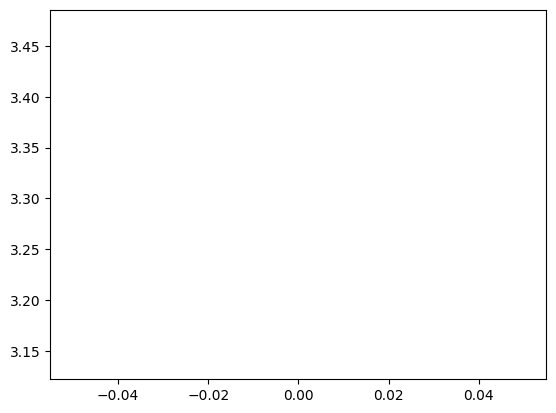

In [203]:
from matplotlib import pyplot as plt
plt.plot(lossi)

1 Tanh tensor(-0.0144, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.7282, device='cuda:0', grad_fn=<StdBackward0>) tensor(15.1875, device='cuda:0')
3 Tanh tensor(0.0322, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6750, device='cuda:0', grad_fn=<StdBackward0>) tensor(8.1875, device='cuda:0')
5 Tanh tensor(0.0034, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6498, device='cuda:0', grad_fn=<StdBackward0>) tensor(6.3125, device='cuda:0')
7 Tanh tensor(0.0145, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6445, device='cuda:0', grad_fn=<StdBackward0>) tensor(4.6875, device='cuda:0')
9 Tanh tensor(-0.0038, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6455, device='cuda:0', grad_fn=<StdBackward0>) tensor(5.6250, device='cuda:0')


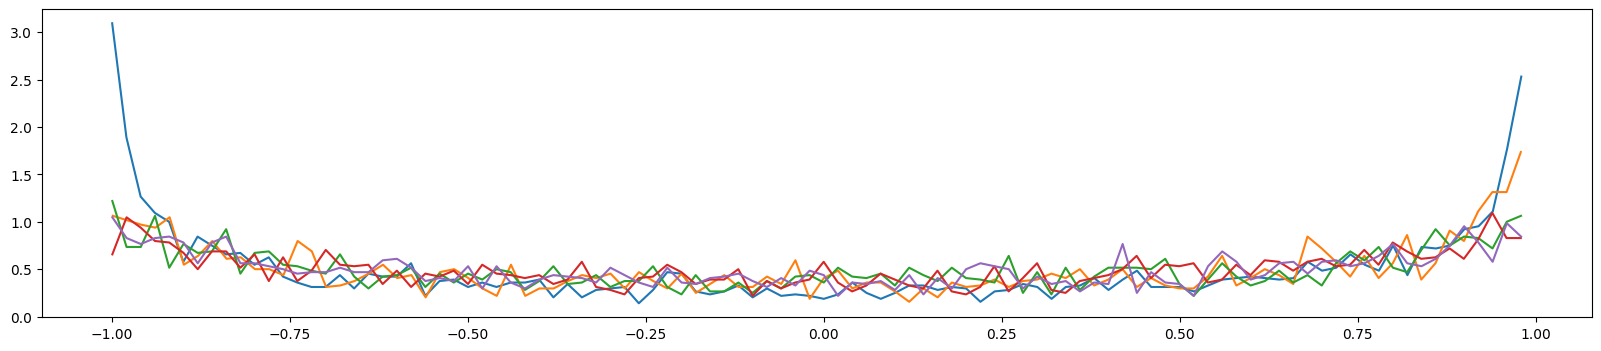

In [207]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(i, layer.__class__.__name__, t.mean(), t.std(), ((t.abs() > 0.97).float().mean()*100))
        t_cpu = t.cpu()
        hy, hx = torch.histogram(t_cpu, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

In [163]:
def print_graph(fn, level=0):
    if fn is None:
        return
    print("--" * level + f"> {fn.__class__.__name__}")
    if hasattr(fn, 'next_functions'):
        for next_fn in fn.next_functions:
            if next_fn[0]:  # Check if it's not None
                print_graph(next_fn[0], level + 1)

# Print the computational graph for 'output'
print_graph(output.grad_fn)


> NllLossBackward0
--> LogSoftmaxBackward0
----> AddBackward0
------> MmBackward0
--------> TanhBackward0
----------> AddBackward0
------------> MmBackward0
--------------> TanhBackward0
----------------> AddBackward0
------------------> MmBackward0
--------------------> ViewBackward0
----------------------> IndexBackward0
------------------------> AccumulateGrad
--------------------> AccumulateGrad
------------------> AccumulateGrad
--------------> AccumulateGrad
------------> AccumulateGrad
--------> AccumulateGrad
------> AccumulateGrad


In [79]:
indexes  = torch.randint(0, X.shape[0], (batch_size, ), device=device)
X_batch, Y_batch = X[indexes], Y[indexes]

In [89]:
C[X_batch].shape

torch.Size([64, 3, 10])

In [90]:
X_batch.shape

torch.Size([64, 3])

In [116]:
x = C[X_batch].view(-1, 30)
for layer in layers:
    x = layer(x)

tensor(3.3143, device='cuda:0')

In [118]:
x.shape

torch.Size([64, 27])

In [106]:
layers[0](network_in).shape

torch.Size([64, 100])

In [97]:
Y_batch.shape

torch.Size([64])

In [93]:
# question - instead of predicting the logit .. can we predict the embeddding and then KNN ?